# Project 2: Understanding and Training Classification Models
## Regardless of the level you are in this course, you are NOT allowed to use import tools from the scipy or sci-kit learn.  The only imports allowed on this project are pandas, numpy, and matplotlib (or plotly/seaborn if you prefer).

### Name:
### Course Level:

## Due: Friday, Feb. 28, 2025

**Introduction:**
* In this project, we explore the application of classification using: a) Logistic Regression and b) Multiclass Logistic Regression. The project will be broken into sections in which students registered for CSC 448 will complete the first section, CSC 548 students will complete the first and second section.

**Objectives:**
* The objective of this project is to implement different classification models to analyze real-world datasets, understand the relationship between variables, and perform classifications.  Additionally, students will gain experience understanding optimization techniques, linear algebra, and subspace learning.

## All Students

* The first problem we aim to analyze is a a binary classifier to determine the likelihood of a students academic success based on 36 different features (i.e., $\textbf{x} \in \mathbb{R}^{36}$).  Download the dataset [Here](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) along with a description of what the features represent.

**Problem A (65pts)**

1 (5pts). The first thing you'll need to do is read the data in, and then decide how best to handle data of different types, e.g., the target variables in this case are catgorical (dropout, enrolled, and graduate).  <u>Because we're interested in a binary classification</u>, let's just treat the "enrolled" the same as "graduate".  This will allow for the target to be [0,1] where 0 corresponds to a dropout and 1 means they are either enrolled or graduated.

* Normally, we'd do some Exploritory Data Analysis (EDA) to see what features were the best to use for predictors of success, however in the problem let's just assume they are all important and equally weighted.
* You will also need to split the dataset into a training set, and testing set (don't worry about a validation set here).  To accomplish this, randomly select 80% of the data for training and use the remaining 20% for testing and evaluation.
    * Note: You should first sort the data into the two classes so you can ensure you grab 80% from each class to form your training/testing set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

student_data = pd.read_csv("data.csv", sep=';')

# Convert target variable to binary (0 for dropout, 1 for enrolled or graduate)
student_data['Target'] = student_data['Target'].apply(lambda x: 0 if x == 'Dropout' else 1)

# Separate features and target
x_input = student_data.drop('Target', axis=1).values
t_target = student_data['Target'].values

# Normalize features
x_input = (x_input - np.mean(x_input, axis=0)) / np.std(x_input, axis=0)

# Function to split dataset into training and testing sets with stratification
def stratified_split(x_input, t_target, train_ratio=0.8, seed=None):
    np.random.seed(seed)
    
    # Get indices for each class
    class_0_indices = np.where(t_target == 0)[0]
    class_1_indices = np.where(t_target == 1)[0]
    
    # Shuffle indices for each class
    np.random.shuffle(class_0_indices)
    np.random.shuffle(class_1_indices)
    
    # Calculate split points for each class
    split_0 = int(train_ratio * len(class_0_indices))
    split_1 = int(train_ratio * len(class_1_indices))
    
    # Combine training and testing indices for each class
    train_indices = np.concatenate((class_0_indices[:split_0], class_1_indices[:split_1]))
    test_indices = np.concatenate((class_0_indices[split_0:], class_1_indices[split_1:]))
    
    # Shuffle the combined indices to mix classes
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    
    # Split the data
    x_train, t_train = x_input[train_indices], t_target[train_indices]
    x_test, t_test = x_input[test_indices], t_target[test_indices]
    
    return x_train, t_train, x_test, t_test

2 (10pts). Next, write a function to evaluate how well the model performs (for this we can just use classification rate as the metric - # of correct classifications).  Note this is a rate so should return the accuracy of your model:
$$
    CR = \frac{\text{Correct Classification}}{\text{All Instances Tested}}
$$

In [2]:
# Function definition here, returns the classification rate between your models predicted target and the true value #
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def ClassificationRate(m_model_params, x_input, t_target):
    # Add bias term
    X = np.hstack((np.ones((x_input.shape[0], 1)), x_input))
    
    # Calculate model predictions
    z = np.dot(X, m_model_params)
    z = np.clip(z, -500, 500)  # Avoid overflow
    y_pred = sigmoid(z)  # Sigmoid function
    
    # Convert to binary predictions
    predictions = (y_pred >= 0.5).astype(int)
    
    # Return class rate betn model predicted target and true value
    return np.mean(predictions == t_target)


3 (40pts). Next write a function (called LogisticRegression) to learn the model parameters using gradient descent (or stochastic gradietn descent if you choose). 
    - The function will take as input, the features (x_input), the target values (t_target), and learning rate. (only using the training set!!!!!)
    - The function will return the model parameters.

* **Hint**:  You might consider creating a "helper" function to compute the gradient descent for you.

**Note**  
* You should assume the model takes the form
$$
    y = \sigma \left( w_0 + \sum_{j=1}^M x_j w_j \right) = \sigma (\textbf{w}^T \textbf{x} + w_0),
$$
where $j$ corresponds to the $j^{\text{th}}$ feature, and recall
$$
    \sigma (z) = \frac{1}{1 + \exp(-z)}.
$$

* **Note:** We derived the gradients for the weight updates as:
$$
    \frac{\partial \ell(\textbf{w})}{\partial w_j} = \sum_{n=1}^N \left( x_j^{(n)} \left( t^{(n)} - \underbrace{\frac{1}{1 + \text{exp}(-z^{(n)})}}_{p(t^{(n)}=1|\textbf{x}^{(n)})} \right) \right),
$$
where recall that $j$ is the $j^\text{th}$ dimension of the $n^\text{th}$ training sample.

In [3]:
def LogisticRegression(x_input, t_target, l_learning_rate,max_iterations=10000):
    # Add bias term to input features
    X = np.hstack((np.ones((x_input.shape[0], 1)), x_input))
    
    # Initialize weights
    num_features = X.shape[1]
    w = np.zeros(num_features)    
    
    # Threshold for convergence
    tolerance = 1e-5
    
    for iteration in range(max_iterations):
        # Calculate model predictions
        z = np.dot(X, w)
        z = np.clip(z, -500, 500)  # Avoid overflow
        y_pred = sigmoid(z) # Sigmoid function
        
        # Compute gradient
        gradient = np.dot(X.T, (y_pred - t_target)) / len(t_target)
        w_new = w - l_learning_rate * gradient
        
        if np.linalg.norm(w_new - w) < tolerance:
            break
        w = w_new
    
    return w

4 (10pts). Evaluate the performance of the classifier.  Similar to k-fold cross validation, to get a good idea of how well your model is performing, do an 80/20 split, and run 5-fold validation on the splits.  

**Example:** Do a random 80/20 split.  Using 80% of the data, train your model and test on the 20% remaining.  Do this at least 5 times (grabbing a new random 80/20 split of the data) and compute the mean and devation for the classification accuracy.

* Note: This is NOT k-fold, but it will give you a better idea about how well your model is working, etc.

In [4]:
# Model evaluation (display the mean and deviation of the classification rate) #
# Train a single model
k = 5 # folds
learning_rate = 0.001
training_ratio = 0.8
base_seed = 2
classification_rates = []

for i in range(k):
    run = i+1
    
    x_train, t_train, x_test, t_test = stratified_split(x_input, t_target, training_ratio, run*base_seed)
    
    w = LogisticRegression(x_train, t_train, learning_rate)
    
    cr = ClassificationRate(w, x_test, t_test)
    
    classification_rates.append(cr)
    
    print(f"Run {run}: Classification Accuracy: {cr:.4f}")

mean_cr = np.mean(classification_rates)
std_cr = np.std(classification_rates)

print(f"\n5-fold validation: Mean CR = {mean_cr:.4f}, Std CR = {std_cr:.4f}")

Run 1: Classification Accuracy: 0.8657
Run 2: Classification Accuracy: 0.8646
Run 3: Classification Accuracy: 0.8747
Run 4: Classification Accuracy: 0.8239
Run 5: Classification Accuracy: 0.8657

5-fold validation: Mean CR = 0.8589, Std CR = 0.0179


**Problem B (25pts)**
1 (5pts). Let's up the complexity a bit.  Here, we're interested in understanding how multiclass classification works.  Let's investigate a 3-class problem by looking at the IRIS dataset (download [Here](https://archive.ics.uci.edu/dataset/53/iris)).  This dataset contains 150 instances relating three different IRIS types (4 different features for each of the 150 samples).  Similar to the above problem, our first step is to download the data and get the data into our notebook.  Let's generate three different scatter plots to see what we're dealing with:

- One looking at Sepial Length vs. Sepial Width vs. Petal Length (i.e., the first three features)
- One looking at Sepial Length vs. Sepial Width vs. Petal Width
- One looking at Sepial Width vs. Petal Length vs. Petal Width

* **Note:** These should be on a single figure with three different subplots for each.  The goal is to be able to investigate the class separability based on the different features.

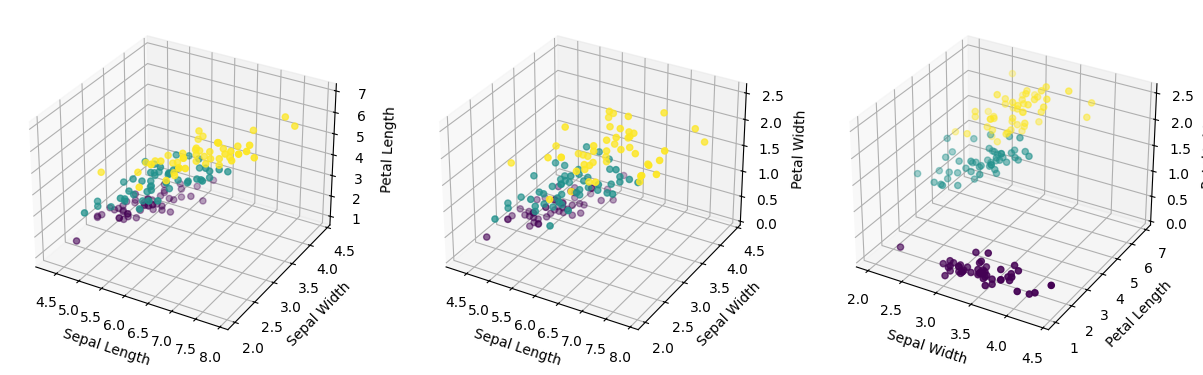

In [5]:
# 3D scatter for the three different plots outlined above #
from mpl_toolkits.mplot3d import Axes3D

# Load the IRIS dataset
iris_data = pd.read_csv('bezdekiris.data', header=None)
iris_data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

# Extract features and target
features = iris_data.iloc[:, :-1].values
target_labels = iris_data.iloc[:, -1].values

# Convert species labels to numeric
unique_species = np.unique(target_labels)
target = np.zeros(len(target_labels), dtype=int)
target = np.array([np.where(unique_species == species)[0][0] for species in target_labels])

# Create one-hot encoded target
num_classes = len(unique_species)
t_onehot = np.zeros((len(target), num_classes))
t_onehot = np.eye(num_classes)[target]

# Create 3D scatter plots
fig = plt.figure(figsize=(15, 5))

# Sepal Length vs. Sepal Width vs. Petal Length
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(iris_data['sepal_length'], iris_data['sepal_width'], iris_data['petal_length'], c=iris_data['class'].astype('category').cat.codes)
ax1.set_xlabel('Sepal Length')
ax1.set_ylabel('Sepal Width')
ax1.set_zlabel('Petal Length')

# Sepal Length vs. Sepal Width vs. Petal Width
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(iris_data['sepal_length'], iris_data['sepal_width'], iris_data['petal_width'], c=iris_data['class'].astype('category').cat.codes)
ax2.set_xlabel('Sepal Length')
ax2.set_ylabel('Sepal Width')
ax2.set_zlabel('Petal Width')

# Sepal Width vs. Petal Length vs. Petal Width
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(iris_data['sepal_width'], iris_data['petal_length'], iris_data['petal_width'], c=iris_data['class'].astype('category').cat.codes)
ax3.set_xlabel('Sepal Width')
ax3.set_ylabel('Petal Length')
ax3.set_zlabel('Petal Width')

plt.show()

2 (15pts). Assuming a linear regression model, with a softmax output, write a function called LogRegMultClass(t_target, x_input, l_learning_rate) that returns the model paramters.

* **Note:** Similar to the above, you should use an 80/20 split to divide the data into a training vs. testing set.  You might want to think about how you can use your Gradient descent helper function in Problem A to cmpute the gradients for this problem as well.
* **Hint:** You might consider writing a quick helper function to perform the softmax output, and recall:
$$
            \text{softmax}(z_1, \dots, z_k) = \left[
            \begin{array}{c}
                \frac{\exp{(z_1)}}{\sum_{j=1}^k \exp{(z_j)}}\\
                \vdots \\
                \frac{\exp{(z_k)}}{\sum_{j=1}^k \exp{(z_j)}}\\
            \end{array}
            \right]
$$ 

In [6]:
# Perform multiclass logistic regression #
# Compute softmax values for each set of scores in z
def softmax(z):
    # Subtract max for numerical stability
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Multiclass Logistic Regression
def LogRegMultClass(t_target, x_input, l_learning_rate):
    # Add bias term to input features
    X = np.hstack((np.ones((x_input.shape[0], 1)), x_input))
    
    # Initialize weights (to zero)
    num_samples, num_features = X.shape
    num_classes = t_target.shape[1]
    w = np.zeros((num_features, num_classes))
    
    # Maximum number of iterations for gradient descent
    max_iterations = 10000
    
    # Threshold for convergence
    convergence_threshold = 1e-5
    
    prev_loss = float('inf')

    for iteration in range(max_iterations):
        # Compute logits
        z = np.dot(X, w)
        
        # Calc softmax!
        y_pred = softmax(z)
        
        # Compute error
        error = t_target - y_pred
        
        # Compute gradient
        gradient = np.dot(X.T, error)
        
        # Update weights
        w += l_learning_rate * gradient
        
        # Compute loss
        loss = -np.mean(np.sum(t_target * np.log(y_pred + 1e-10), axis=1))
        
        # Check for convergence
        if abs(prev_loss - loss) < convergence_threshold:
            break
        prev_loss = loss

    return w

# Classification Rate
def MultiClassRate(m_model_params, x_input, t_target):
    # Add bias term to input features
    X = np.hstack((np.ones((x_input.shape[0], 1)), x_input))
    
    # Compute predicted probabilities w softmax
    y_pred = softmax(np.dot(X, m_model_params))
    
    # Get predicted class lables
    pred_class = np.argmax(y_pred, axis=1)
    
    # Get true class labels
    true_class = np.argmax(t_target, axis=1)
    
    # Compute classification accuracy
    return np.sum(pred_class == true_class) / len(true_class)



3 (5pts). To investigate the how well the classifier works, similar to Problem A.4, evaluate the model using 5-fold validation and present the mean and deviation for the classification rates.

In [7]:
def evaluate_model(features, t_onehot, num_classes, k=5, learning_rate=0.001, base_seed=8):
    classification_rates = []

    # Convert one-hot encoded targets back to class labels
    class_labels = np.argmax(t_onehot, axis=1)

    for i in range(k):
        np.random.seed(i * base_seed)  # ensure unique seed

        train_indices, test_indices = [], []

        # Stratified splitting
        for c in range(num_classes):
            # Randomize split
            class_indices = np.where(class_labels == c)[0]
            np.random.shuffle(class_indices)

            # 80% : training
            train_size = int(0.8 * len(class_indices))
            train_indices.extend(class_indices[:train_size])
            test_indices.extend(class_indices[train_size:])

        # Shuffle training and testing indices to mix classes
        np.random.shuffle(train_indices)
        np.random.shuffle(test_indices)

        # Split data into training and testing sets
        x_train, t_train = features[train_indices], t_onehot[train_indices]
        x_test, t_test = features[test_indices], t_onehot[test_indices]

        # Train multiclass logistic regression model
        w = LogRegMultClass(t_train, x_train, learning_rate)

        # Evaluate model on the testing set
        cr = MultiClassRate(w, x_test, t_test)

        print(f"Run {i+1}: Classification Accuracy: {cr:.4f}")
        classification_rates.append(cr)

    # Calculate the mean and standard deviation of classification rates
    mean_cr = np.mean(classification_rates)
    std_cr = np.std(classification_rates)

    print(f"\n{k}-fold validation: Mean CR = {mean_cr:.4f}, Std CR = {std_cr:.4f}")

    return mean_cr, std_cr

mean_cr, std_cr = evaluate_model(
    features=features,  # Feature matrix
    t_onehot=t_onehot,  # One-hot encoded target labels
    num_classes=3,      # Number of classes (adjust as needed)
    k=5,                # Number of folds
    learning_rate=0.01, # Learning rate for logistic regression
    base_seed=8         # Base seed for reproducibility
)

Run 1: Classification Accuracy: 0.9667
Run 2: Classification Accuracy: 0.9333
Run 3: Classification Accuracy: 1.0000
Run 4: Classification Accuracy: 0.9667
Run 5: Classification Accuracy: 0.9333

5-fold validation: Mean CR = 0.9600, Std CR = 0.0249


**Problem C (10pts)**
* In Problem B, you investigated the IRIS dataset.  In Problem C, we'll look at constructing the decision boundary between setosa vs. virginica and versicolor (just assume that virginica and versicolor belong to the same class - e.g., this is a binary classification problem).
* Furhtermore, remove all features from the dataset except sepal length and sepal width (this will result in a 2-dimensional feature space)
* Using our logistic regression model, learn the model parameters as in Problem A, and display a plot showing the two different classes (in different colors) along with the line illustrating this decision boundary between the two classes. [Example of what we're looking for can be found here](https://drive.google.com/file/d/1_OpNJGUHbwiqQhNlIj_2H2Htib-MJcfi/view?usp=share_link)



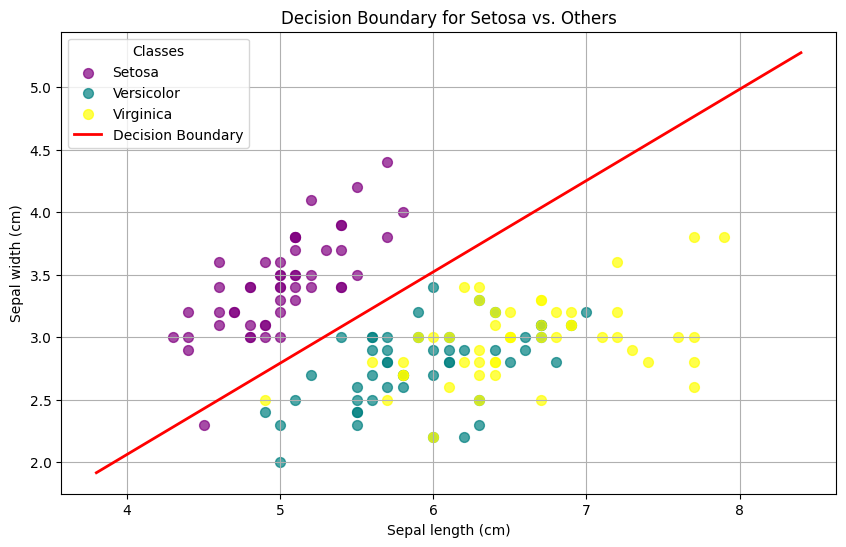

In [8]:
# Extract features (first two columns) and species labels
x_input = iris_data.iloc[:, :2].values  # Sepal length and sepal width
species_labels = iris_data.iloc[:, -1].values  # Species labels

# Create binary classification: Setosa (0) vs. Others (1)
t_target = np.zeros(len(species_labels))
t_target[species_labels != 'Iris-setosa'] = 1

# Split data for training
np.random.seed(69)
indices = np.arange(len(t_target))
np.random.shuffle(indices)
train_size = int(0.8 * len(indices))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

x_train, t_train = x_input[train_indices], t_target[train_indices]

learning_rate = 0.8
w = LogisticRegression(x_train, t_train, learning_rate,5000)

# Plot Decision Boundary
plt.figure(figsize=(10, 6))

# Plot the classes with the correct colors
setosa_indices = species_labels == 'Iris-setosa'
versicolor_indices = species_labels == 'Iris-versicolor'
virginica_indices = species_labels == 'Iris-virginica'

plt.scatter(x_input[setosa_indices, 0], x_input[setosa_indices, 1], 
            c='purple', label='Setosa', s=50, alpha=0.7)
plt.scatter(x_input[versicolor_indices, 0], x_input[versicolor_indices, 1], 
            c='teal', label='Versicolor', s=50, alpha=0.7)
plt.scatter(x_input[virginica_indices, 0], x_input[virginica_indices, 1], 
            c='yellow', label='Virginica', s=50, alpha=0.7)

# Create the decision boundary
x_min, x_max = x_input[:, 0].min() - 0.5, x_input[:, 0].max() + 0.5
x_vals = np.linspace(x_min, x_max, 100)

# Decision boundary: w[0] + w[1]*x + w[2]*y = 0 => y = -(w[0] + w[1]*x)/w[2]
if w[2] != 0:  # Avoid division by zero
    y_vals = -(w[0] + w[1] * x_vals) / w[2]
    plt.plot(x_vals, y_vals, 'r-', linewidth=2, label="Decision Boundary")
else:
    # If w[2] is zero, the decision boundary is vertical
    x_boundary = -w[0] / w[1]  # Solve for x when y is irrelevant
    plt.axvline(x=x_boundary, color='r', linewidth=2, label="Decision Boundary")

plt.xlabel('Sepal length (cm)')
plt.ylabel('Sepal width (cm)')
plt.title('Decision Boundary for Setosa vs. Others')
plt.legend(title="Classes")
plt.grid(True)
plt.show()